##### 1. Import package from Library

In [1]:
from platform import python_version
print(python_version())
import torch
print(torch.__version__)
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

import time

3.6.3
1.3.0


In [2]:
DATA_DIR = ''
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
def to_numpy(tensor):
    '''converts a GPU tensor to a numpy array'''
    return tensor.cpu().detach().numpy()

##### 2. info about data from h5 file (for ex. type0)

ps. Section 2 works both of type0 and type1! 

##### 2.i. To obtain key within .h5 file by reading

In [3]:
def to_numpy(tensor):
    '''converts a GPU tensor to a numpy array'''
    return tensor.cpu().detach().numpy()

In [4]:
f = h5.File('./el_data.h5', 'r') ## gives group
print('\033[1;35m Key name:\033[1;m', list(f.keys()))

 Key name: ['em_barrel_Lr0', 'em_barrel_Lr1', 'em_barrel_Lr1_fine', 'em_barrel_Lr2', 'em_barrel_Lr3', 'eventNumber', 'p_Eratio', 'p_LHLoose', 'p_LHMedium', 'p_LHTight', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_TruthType', 'p_d0', 'p_d0Sig', 'p_dPOverP', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_e', 'p_et_calo', 'p_eta', 'p_f1', 'p_f3', 'p_iffTruth', 'p_numberOfSCTHits', 'p_phi', 'p_pt_track', 'p_truth_eta', 'p_truth_phi', 'p_truth_pt', 'p_weta2', 'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3', 'tracks', 'true_m']


In [5]:
file_name = h5.File('./el_data.h5', 'r') ## gives group
keys = list(file_name.keys())
print(keys)
#print(list(file_name[keys[0]]))
#print(list(file_name[keys[1]]))
#print(list(file_name[list(file_name.keys())[0]])) ## or
file_name.close()

['em_barrel_Lr0', 'em_barrel_Lr1', 'em_barrel_Lr1_fine', 'em_barrel_Lr2', 'em_barrel_Lr3', 'eventNumber', 'p_Eratio', 'p_LHLoose', 'p_LHMedium', 'p_LHTight', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_TruthType', 'p_d0', 'p_d0Sig', 'p_dPOverP', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_e', 'p_et_calo', 'p_eta', 'p_f1', 'p_f3', 'p_iffTruth', 'p_numberOfSCTHits', 'p_phi', 'p_pt_track', 'p_truth_eta', 'p_truth_phi', 'p_truth_pt', 'p_weta2', 'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3', 'tracks', 'true_m']


In [6]:
def make_sample(data_file, batch_size, all_features, images, upscale=False, denormalize=False, index=0):
    data = h5.File(data_file, 'r')
    idx_1, idx_2 = index*batch_size, (index+1)*batch_size
    sample_dict  = dict([key, data[key][idx_1:idx_2]] for key in all_features)
    if images != [] and denormalize:
        energy = sample_dict['p_e']
        for key in images: sample_dict[key] = sample_dict[key] * energy[:, np.newaxis, np.newaxis]
        sample_dict['tracks'][:,:,0] = sample_dict['tracks'][:,:,0] * energy[:, np.newaxis]
    if images != [] and upscale:
        for i in images: sample_dict[i] = resize_images(np.float32(sample_dict[i]), target_shape=(56,11))
    return sample_dict

In [7]:
images    = ['em_barrel_Lr0',  'em_barrel_Lr1', 'em_barrel_Lr2', 'em_barrel_Lr3',
             'tile_barrel_Lr1', 'tile_barrel_Lr2', 'tile_barrel_Lr3']
tracks    = ['tracks' ]
scalars   = ['p_Eratio', 'p_Reta', 'p_Rhad', 'p_Rphi', 'p_TRTPID', 'p_d0', 'p_d0Sig', 'p_dPOverP',
             'p_deltaPhiRescaled2', 'p_deltaEta1', 'p_f1', 'p_f3', 'p_numberOfSCTHits', 'p_weta2']
others    = ['p_TruthType', 'p_iffTruth', 'p_LHTight', 'p_LHMedium', 'p_LHLoose', 'p_e']
#train_features = {'images':images, 'tracks':tracks, 'scalars':scalars}
train_features = {'images':images, 'tracks':[], 'scalars':[]}
all_features   = np.sum(list(train_features.values())) + others
if train_features['images'] == []: args.n_type = 'FCN'

In [8]:
data_file = './el_data.h5'

In [16]:
#n_e = 1000000
n_e = 100000
xtrain_data = make_sample(data_file, n_e, all_features, train_features['images'], upscale=False)

In [17]:
train_data = [ np.expand_dims(np.float32(xtrain_data[key]),axis = 1)  for key in np.sum(list(train_features.values()))]
#train_data = [np.float32(train_data[key])[:,np.newaxis,:,:]  for key in np.sum(list(train_features.values()))]
#train_data = [np.float32(train_data[key]) for key in np.sum(list(train_features.values()))]

In [18]:
for element in train_data:
    print(element.shape)

(100000, 1, 7, 11)
(100000, 1, 7, 11)
(100000, 1, 7, 11)
(100000, 1, 7, 11)
(100000, 1, 7, 11)
(100000, 1, 7, 11)
(100000, 1, 7, 11)


In [19]:
x = np.concatenate(train_data, axis=1)
print(x.shape)

(100000, 7, 7, 11)


In [20]:
def make_labels(data, n_classes):
    if   n_classes == 2:
        labels = np.where(np.logical_or(data['p_TruthType']==2, data['p_TruthType']==4), 0, 1)
    elif n_classes == 5:
        truth  = data['p_iffTruth']
        labels = np.where(truth==2, 0, 4     )
        labels = np.where(truth==3, 1, labels)
        labels = np.where(np.logical_or (truth==1, truth==10), 2, labels)
        labels = np.where(np.logical_and(truth>=7, truth<= 9), 3, labels)
    elif n_classes == 9:
        labels = data['p_iffTruth']
        labels = np.where(labels== 9, 4, labels)
        labels = np.where(labels==10, 6, labels)
    else:
        print('\nCLASSIFIER:', n_classes, 'classes not supported -> exiting program\n')
        sys.exit()
    return labels

In [21]:
n_classes = 2
y = make_labels(xtrain_data, n_classes)
print(y.shape)

(100000,)


##### 2.iii. To read the content of .h5 files as an datatype=float

##### 3. Labels

##### 5. Access data

##### 6. Load dataset AND split all dataset into two-subsets as a train and a validation AND load both of them

In [22]:
## Prepare training data
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)
shuffle_idx = np.random.permutation(x.shape[0])
x = x[shuffle_idx]
y = y[shuffle_idx]

train_frac = 0.9
idx = int(train_frac * len(x))
x_train, x_test = x[:idx], x[idx:]
y_train, y_test = y[:idx], y[idx:]

train_tensor_x = torch.stack([torch.Tensor(i) for i in x_train]) 
train_tensor_y = torch.stack([torch.zeros([1])+i for i in y_train])
train_tensor_y_long = train_tensor_y.long()

test_tensor_x = torch.stack([torch.Tensor(i) for i in x_test]) 
test_tensor_y = torch.stack([torch.zeros([1])+i for i in y_test])## 32-bit floating point
test_tensor_y_long = test_tensor_y.long() ## 64-bit integer (signed)

print('\033[1;33m train_tensor_x type: \033[', train_tensor_x.type())
print('\033[1;33m train_tensor_x dtype: \033[', train_tensor_x.dtype)

print('\033[1;33m train_tensor_y type: \033[', train_tensor_y.type())

print('\033[1;33m train_tensor_y_long type: \033[', train_tensor_y_long.type())
print('\033[1;33m train_tensor_y_long dtype: \033[', train_tensor_y_long.dtype)

print('\033[1;35m test_tensor_x type: \033[', test_tensor_x.type())
print('\033[1;35m test_tensor_x dtype: \033[', test_tensor_x.dtype)

print('\033[1;35m test_tensor_y type: \033[', test_tensor_y.type())

print('\033[1;35m test_tensor_y_long type: \033[', test_tensor_y_long.type())
print('\033[1;35m test_tensor_y_long dtype: \033[', test_tensor_y_long.dtype)

print('\033[1;36m tensor_x num of dims: \033[1;m', train_tensor_x.dim())
print('\033[1;36m tensor_y num of dims: \033[1;m', train_tensor_y_long.dim())

print('\033[1;34m tensor_x Shape:\033[1;m', train_tensor_x.shape)
print('\033[1;34m tensor_y Shape:\033[1;m', train_tensor_y_long.shape)

print('\033[1;36m tensor_x num of dims: \033[1;m', test_tensor_x.dim())
print('\033[1;36m tensor_y num of dims: \033[1;m', test_tensor_y_long.dim())

print('\033[1;34m tensor_x Shape:\033[1;m', test_tensor_x.shape)
print('\033[1;34m tensor_y Shape:\033[1;m', test_tensor_y_long.shape)

 train_tensor_x type: [ torch.cuda.FloatTensor
 train_tensor_x dtype: [ torch.float32
 train_tensor_y type: [ torch.cuda.FloatTensor
 train_tensor_y_long type: [ torch.cuda.LongTensor
 train_tensor_y_long dtype: [ torch.int64
 test_tensor_x type: [ torch.cuda.FloatTensor
 test_tensor_x dtype: [ torch.float32
 test_tensor_y type: [ torch.cuda.FloatTensor
 test_tensor_y_long type: [ torch.cuda.LongTensor
 test_tensor_y_long dtype: [ torch.int64
 tensor_x num of dims:  4
 tensor_y num of dims:  2
 tensor_x Shape: torch.Size([90000, 7, 7, 11])
 tensor_y Shape: torch.Size([90000, 1])
 tensor_x num of dims:  4
 tensor_y num of dims:  2
 tensor_x Shape: torch.Size([10000, 7, 7, 11])
 tensor_y Shape: torch.Size([10000, 1])


In [23]:
#torch.cuda.empty_cache()

##### 7. Hyperparameters

In [25]:
## Hyperparameters
#num_epochs=20
num_epochs=40
#num_classes=10
nw=3
bs=512
#bs=64
wd=1e-5
lr=1e-5
momentum=0.9

##### 8. Create the model by defining Network

In [31]:
class Net(nn.Module):        
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(7, 32, kernel_size=2, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1)
        self.conv5_bn = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=1)
        self.conv6_bn = nn.BatchNorm2d(16)
        self.drop_out = nn.Dropout(p=0.5)  
        self.fc1 = nn.Linear(13*17* 16,10)
        self.fc2 = nn.Linear(10, 2)
        
        
    def forward(self, out):
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2_bn((self.conv2(out))))
        out = F.relu(self.conv3_bn((self.conv3(out))))
        out = F.relu(self.conv4_bn((self.conv4(out))))
        out = F.relu(self.conv5_bn((self.conv5(out))))
        out = F.relu(self.conv6_bn((self.conv6(out))))
        out = out.view(-1, 3536) 
        out = self.drop_out(out)  
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

model = Net().to(device)

summary(model, (7,7,11))

print('\n')

print('\033[1;35m Net model: \033[1;m \n', model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 8, 12]             928
            Conv2d-2            [-1, 32, 9, 13]           4,128
       BatchNorm2d-3            [-1, 32, 9, 13]              64
            Conv2d-4           [-1, 32, 10, 14]           4,128
       BatchNorm2d-5           [-1, 32, 10, 14]              64
            Conv2d-6           [-1, 32, 11, 15]           4,128
       BatchNorm2d-7           [-1, 32, 11, 15]              64
            Conv2d-8           [-1, 32, 12, 16]           4,128
       BatchNorm2d-9           [-1, 32, 12, 16]              64
           Conv2d-10           [-1, 16, 13, 17]           2,064
      BatchNorm2d-11           [-1, 16, 13, 17]              32
          Dropout-12                 [-1, 3536]               0
           Linear-13                   [-1, 10]          35,370
           Linear-14                   

##### 9. Loss and Optimizer

In [27]:
class Net(nn.Module):        
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(7, 32, kernel_size=2, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1)
        self.conv5_bn = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=1)
        self.conv6_bn = nn.BatchNorm2d(16)
        self.drop_out = nn.Dropout(p=0.5)  
        self.fc1 = nn.Linear(13*17* 16, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 500)
        self.fc5 = nn.Linear(500, 500)
        self.fc6 = nn.Linear(500, 500)
        self.fc7 = nn.Linear(500, 500)
        self.fc8 = nn.Linear(500, 500)
        self.fc9 = nn.Linear(500, 500)
        self.fc10 = nn.Linear(500, 2)
        
        
    def forward(self, out):
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2_bn((self.conv2(out))))
        out = F.relu(self.conv3_bn((self.conv3(out))))
        out = F.relu(self.conv4_bn((self.conv4(out))))
        out = F.relu(self.conv5_bn((self.conv5(out))))
        out = F.relu(self.conv6_bn((self.conv6(out))))
        out = out.view(-1, 3536) 
        out = self.drop_out(out)  
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = F.relu(self.fc5(out))
        out = F.relu(self.fc6(out))
        out = F.relu(self.fc7(out))
        out = F.relu(self.fc8(out))
        out = F.relu(self.fc9(out))
        out = self.fc10(out)
        return out
    

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

model = Net().to(device)

summary(model, (7,7,11))

print('\n')

print('\033[1;35m Net model: \033[1;m \n', model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 8, 12]             928
            Conv2d-2            [-1, 32, 9, 13]           4,128
       BatchNorm2d-3            [-1, 32, 9, 13]              64
            Conv2d-4           [-1, 32, 10, 14]           4,128
       BatchNorm2d-5           [-1, 32, 10, 14]              64
            Conv2d-6           [-1, 32, 11, 15]           4,128
       BatchNorm2d-7           [-1, 32, 11, 15]              64
            Conv2d-8           [-1, 32, 12, 16]           4,128
       BatchNorm2d-9           [-1, 32, 12, 16]              64
           Conv2d-10           [-1, 16, 13, 17]           2,064
      BatchNorm2d-11           [-1, 16, 13, 17]              32
          Dropout-12                 [-1, 3536]               0
           Linear-13                  [-1, 500]       1,768,500
           Linear-14                  [

##### 10. Train and Validation parts of the model 

In [32]:
from __future__ import absolute_import
import poutyne
from pkg_resources import parse_version
assert parse_version(poutyne.__version__) >= parse_version('0.4'), "Please update your Poutyne version."
from poutyne.framework import Model
from poutyne.framework import Callback
from livelossplot import PlotLosses
from IPython.display import clear_output

In [33]:
## Plot Model
class Plot(Callback):
    def on_train_begin(self, logs={}):
        self.i=0.0
        self.x=[]
        
        self.losses=[]
        self.val_losses=[]
        self.acc=[]
        self.val_acc=[]
        
        self.fig=plt.figure()
        self.logs=[]

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i+=1
        clear_output(wait=True)        
     
        LossAcc=plt.figure(figsize=(10, 5))
        ax1=LossAcc.add_subplot(1,2,1)
        ax1.plot(self.x, self.losses, label='loss', color='pink',lw=2)
        ax1.plot(self.x, self.val_losses, label='val_loss', color='c',lw=2)
        ax1.set_title('Loss and Val_Loss (bs={}, lr={})'.format(bs, lr))
        ax1.set_ylabel('Loss(Num. of Epochs)')
        ax1.set_xlabel('Num. of Epochs')
        ax1.legend()
        
        ax2=LossAcc.add_subplot(1,2,2)
        ax2.plot(self.x, self.acc, label='acc', color='pink',lw=2)
        ax2.plot(self.x, self.val_acc, label='val_acc', color='c',lw=2)
        ax2.set_title('Acc and Val_Acc (bs={}, lr={})'.format(bs, lr))
        ax2.set_ylabel('Acc(Num. of Epochs)')
        ax2.set_xlabel('Num. of Epochs')
        ax2.legend()       
        LossAcc.savefig('Loss_and_Acc.pdf')
        
        plt.show();

plot=Plot()

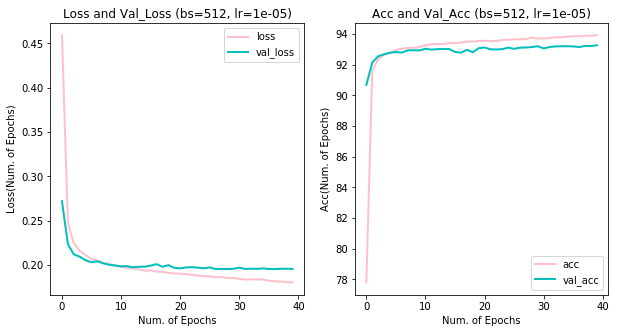

[{'epoch': 1,
  'loss': 0.4590594673315684,
  'time': 2.877786744997138,
  'acc': 77.80111111111111,
  'val_loss': 0.2718772279262543,
  'val_acc': 90.6900000366211},
 {'epoch': 2,
  'loss': 0.24745873641702865,
  'time': 2.861924615019234,
  'acc': 91.61222222222223,
  'val_loss': 0.22339927103519439,
  'val_acc': 92.13999993896485},
 {'epoch': 3,
  'loss': 0.22441192530526055,
  'time': 2.862015095015522,
  'acc': 92.36333333333333,
  'val_loss': 0.21195065817832948,
  'val_acc': 92.55999993896485},
 {'epoch': 4,
  'loss': 0.2158040365987354,
  'time': 2.8639825209975243,
  'acc': 92.66222222222223,
  'val_loss': 0.2093372843503952,
  'val_acc': 92.67999993896484},
 {'epoch': 5,
  'loss': 0.21113652233812544,
  'time': 2.859528191998834,
  'acc': 92.76444444444445,
  'val_loss': 0.20527442677021027,
  'val_acc': 92.78999998779297},
 {'epoch': 6,
  'loss': 0.20667901771333483,
  'time': 2.8581893729860894,
  'acc': 92.96888888888888,
  'val_loss': 0.20305392513275147,
  'val_acc': 92.

In [34]:
model = Model(model, 'sgd', 'cross_entropy', batch_metrics=['accuracy'])
model.fit(train_tensor_x, train_tensor_y_long.squeeze(1),
          validation_data=(test_tensor_x, test_tensor_y_long.squeeze(1)),
          epochs=num_epochs,
          batch_size=bs, callbacks=[plot], verbose=0)

In [35]:
print('\nCLASSIFIER: recovering truth labels (generator batches:',
    len(test_generator), 'x', test_batch_size, 'e)')
y_true = np.concatenate([ test_generator[i][1] for i in np.arange(0,len(test_generator)) ])
y_prob = model.predict_generator(test_generator, verbose=1, workers=n_cpus, use_multiprocessing=True)


def valid_accuracy(y_true, y_prob):
    y_pred = np.argmax(y_prob, axis=1)
    return sum(y_pred==y_true)/len(y_true)

#train_pred = np.argmax(to_numpy(model(train_tensor_x)), axis=1)
#test_pred = np.argmax(to_numpy(model(test_tensor_x)), axis=1)

NameError: name 'test_generator' is not defined

In [ ]:
def get_LLH(data, y_true):
    eff_class0, eff_class1 = [],[]
    for wp in ['p_LHTight', 'p_LHMedium', 'p_LHLoose']:
        y_class0 = data[wp][y_true == 0]
        y_class1 = data[wp][y_true == 1]
        eff_class0.append( np.sum(y_class0 == 0)/len(y_class0) )
        eff_class1.append( np.sum(y_class1 == 0)/len(y_class1) )
    return eff_class0, eff_class1

def plot_ROC_curves(test_sample, y_true, y_prob, ROC_type, tag=''):
    file_name = 'outputs/ROC'+str(ROC_type)+'_curve'+tag+'.png'
    print('CLASSIFIER: saving test sample ROC'+str(ROC_type)+' curve in:   ', file_name)
    eff_class0, eff_class1 = get_LLH(test_sample, y_true)

    #y_prob = y_prob[np.logical_or(y_true==0, y_true==1)]
    #y_true = y_true[np.logical_or(y_true==0, y_true==1)]

    fpr, tpr, threshold    = metrics.roc_curve(y_true, y_prob[:,0], pos_label=0)
    signal_ratio           = len(y_true[y_true==0])/len(y_true)
    accuracy               = tpr*signal_ratio + (1-fpr)*(1-signal_ratio)
    best_tpr, best_fpr     = tpr[np.argmax(accuracy)], fpr[np.argmax(accuracy)]
    colors = [ 'red', 'blue', 'green' ]
    labels = [ 'LLH tight', 'LLH medium', 'LLH loose' ]
    plt.figure(figsize=(12,8))
    pylab.grid(True)
    axes = plt.gca()
    axes.xaxis.set_ticks(np.arange(0, 101, 10))
    plt.xlabel('Signal Efficiency (%)',fontsize=20)
    if ROC_type == 1:
        plt.xlim([0, 100])
        plt.ylim([0, 100.5])
        axes.yaxis.set_ticks(np.arange(0, 101, 10))
        plt.ylabel('Background Rejection (%)',fontsize=20)
        plt.text(22, 34, 'AUC: '+str(format(metrics.auc(fpr,tpr),'.4f')),
                {'color': 'black', 'fontsize': 22}, va="center", ha="center")
        val = plt.plot(100*tpr, 100*(1-fpr), label='Signal vs Bkg', color='#1f77b4')
        plt.scatter( 100*best_tpr, 100*(1-best_fpr), s=30, marker='D', c=val[0].get_color(),
                     label="{0:<16s} {1:>3.2f}%".format('Best Accuracy:',100*max(accuracy)) )
        for LLH in zip( eff_class0, eff_class1, colors, labels ):
            plt.scatter( 100*LLH[0], 100*(1-LLH[1]), s=40, marker='o', c=LLH[2], label='('+\
                         str( format(100*LLH[0],'.1f'))+'%, '+str( format(100*(1-LLH[1]),'.1f') )+\
                         ')'+r'$\rightarrow$'+LLH[3] )
        plt.legend(loc='lower left', fontsize=15, numpoints=3)
        plt.savefig(file_name)
    if ROC_type == 2:
        pylab.grid(False)
        len_0 = len(fpr[fpr==0])
        x_min = min(60, 10*np.floor(10*eff_class0[0]))
        y_max = 100*np.ceil(max(1/fpr[np.argwhere(tpr >= x_min/100)[0]], 1/eff_class1[0])/100)
        plt.xlim([x_min, 100])
        plt.ylim([1,   y_max])
        LLH_scores = [1/fpr[np.argwhere(tpr >= value)[0]] for value in eff_class0]
        for n in np.arange(len(LLH_scores)):
            axes.axhline(LLH_scores[n], xmin=(eff_class0[n]-x_min/100)/(1-x_min/100), xmax=1,
            ls='--', linewidth=0.5, color='#1f77b4')
            axes.axvline(100*eff_class0[n], ymin=abs(1/eff_class1[n]-1)/(plt.yticks()[0][-1]-1),
            ymax=abs(LLH_scores[n]-1)/(plt.yticks()[0][-1]-1), ls='--', linewidth=0.5, color='#1f77b4')
        for val in LLH_scores:
            plt.text(100.2, val, str(int(val)), {'color': '#1f77b4', 'fontsize': 10}, va="center", ha="left")
        axes.yaxis.set_ticks( np.append([1],plt.yticks()[0][1:]) )
        plt.ylabel('1/(Background Efficiency)',fontsize=20)
        val = plt.plot(100*tpr[len_0:], 1/fpr[len_0:], label='Signal vs Bkg', color='#1f77b4')
        plt.scatter( 100*best_tpr, 1/best_fpr, s=30, marker='D', c=val[0].get_color(),
                     label="{0:<15s} {1:>3.2f}%".format('Best Accuracy:',100*max(accuracy)) )
        for LLH in zip( eff_class0, eff_class1, colors, labels ):
            plt.scatter( 100*LLH[0], 1/LLH[1], s=40, marker='o', c=LLH[2], label='('+\
                         str(format(100*LLH[0],'.1f'))+'%, '+str(format(1/LLH[1],'.0f'))+\
                         ')'+r'$\rightarrow$'+LLH[3] )
        plt.legend(loc='upper right', fontsize=15, numpoints=3)
        plt.savefig(file_name)
    if ROC_type == 3:
        best_threshold = threshold[np.argmax(accuracy)]
        plt.xlim([0, 100])
        plt.ylim([max(50, 10*np.round(min(10*accuracy))),10*np.ceil(10*max(accuracy))])
        plt.xlabel('Discrimination Threshold (%)',fontsize=30)
        plt.ylabel('Accuracy (%)',fontsize=30)
        val = plt.plot(100*threshold[1:], 100*accuracy[1:], color='#1f77b4')
        #plt.plot( 100*threshold[1:], 100*tpr[1:], color='r')
        #plt.plot( 100*threshold[1:], 100*(1-fpr[1:]), color='g')
        std_accuracy  = test_accuracy(y_true, y_prob)
        std_threshold = np.argwhere(np.diff(np.sign(accuracy-std_accuracy))).flatten()
        #std_threshold = np.argwhere(accuracy >= std_accuracy)[0].flatten()
        plt.scatter( [ 50], #100*threshold[std_threshold[-1]] ],
                     [ 100*accuracy [std_threshold[-1]] ],
                     s=40, marker='o', c=val[0].get_color(),
                     label="{0:<17s} {1:>2.2f}%".format('Accuracy at 50%:',100*accuracy[std_threshold[-1]]) )
        plt.scatter( 100*best_threshold, 100*max(accuracy), s=40, marker='D', c=val[0].get_color(),
                     label="{0:<16s} {1:>8.2f}%".format('Best Accuracy:',100*max(accuracy)) )
        plt.legend(loc='lower center', fontsize=15, numpoints=3)
        plt.savefig(file_name)

plot_ROC_curves(test_data, y_true, y_prob, ROC_type=1)
plot_ROC_curves(test_data, y_true, y_prob, ROC_type=2)

##### 11. Plot the model for Loss and Acc